## Steel price regression - 환율 선 적용

## 변수 정의
### 1. 국내
* weightA: 철 스크랩, 중량A 평균가

### 2. 철스크랩(Scrap Steel) > 한국의 수입가
* importPriceUSA: 미국산 대형 -벌크 (HMS No.1) (달러/톤)
* importPriceJP: 일본 H2 (백엔/톤)

### 3. 철스크랩(Scrap Steel) > 해외가격(Overseas)
* priceCN: 중국 장쑤 내수가 (달러/톤)
* priceJP: 일본 내수가 (백엔/톤)
* priceUSA_TAIWAN : 미국→대만 (컨테이너) (달러/톤)

### 4. 기타 변수
* stock: 국내 제강사 재고
* USD_KR: 달러 환율(해당일 매매기준율)
* JPY_KR: 엔화 환율(해당일 매매기준율)


### Scrap가 부서공식 
* 스크랩가 = weightA*0.7 + importPriceJP*0.2 + importPriceUSA*0.1

In [79]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

# 데이터 분할:train, test
from sklearn.model_selection import train_test_split
# 분류 Random Forest
from sklearn.ensemble import RandomForestClassifier
# 최적 모델, 파라미터 탐색
from sklearn.model_selection import GridSearchCV
# 모델 성능 평가
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

import seaborn as sns
from statsmodels.formula.api import ols
from statsmodels.api import qqplot,add_constant
import statsmodels.formula.api as smf
from statsmodels.tools.eval_measures import rmse
from sklearn.metrics import r2_score
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [80]:
import matplotlib
# 한글설치 (윈도우 버전)
matplotlib.rc('font', family = 'AppleGothic')
# 음수 표시
matplotlib.rc('axes', unicode_minus=False)
# 실행결과 경고메시지 출력 제외
import warnings
warnings.filterwarnings('ignore')
random_seed = 123
pd.set_option('display.max_rows', 500)

In [81]:
# 시계열 모델에서 예측된 각각의 값들
df = pd.read_csv("./data/input_step1_p50.csv")
#날짜형으로 변환
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
df.tail()

# 계산을 위해 YEAR-Quarter 컬럼 추가 (값 형태 year.quarter)
df['quarter'] = df['date'].dt.year+ (df.date.dt.quarter)*0.1
#Unit 단위 통일 톤/원
df['weightA']= df['weightA'] * 1000
df['gosi'] = df['gosi'] * 1000
#부서 고유공식(1) 적용된 스크랩가 구하기
df['scrap'] = df['weightA']*0.7 + df['importPriceJP']*0.2 + df['importPriceUSA']*0.1

df.head()

,date,date.1,weightA,gosi,priceUSA_TAIWAN,priceJP,priceCN,importPriceUSA,importPriceJP,stock,USD_KR,JPY_KR,scrap,stock_trend,quarter
0,2017-01-06,2017-01-06,295000.0,620000.0,301955.5,260931.7,302432.9,337760.5,334180.0,869.0,1193.5,1027.29,307112.05,1000.161491,2017.1
1,2017-01-13,2017-01-13,280000.0,620000.0,294925.0,263114.0,297745.0,327825.0,329000.0,846.0,1175.0,1023.79,294582.50,999.778174,2017.1
2,2017-01-20,2017-01-20,270000.0,620000.0,294674.0,261391.4,297491.6,327546.0,316980.0,944.0,1174.0,1021.06,285150.60,999.394856,2017.1
3,2017-01-27,2017-01-27,270000.0,620000.0,296437.5,260719.7,294577.5,324337.5,290625.0,1019.0,1162.5,1022.43,279558.75,999.011538,2017.1
4,2017-02-03,2017-02-03,264000.0,620000.0,280356.0,256797.5,291501.3,320571.0,281505.0,1007.0,1149.0,1015.01,273158.10,998.628221,2017.1


In [82]:
df_a = df.groupby(['quarter'])['gosi'].mean().reset_index()
df_b = df.groupby(['quarter'])['scrap'].mean().reset_index()
df_b.head()

,quarter,scrap
0,2017.1,284187.346154
1,2017.2,266460.866667
2,2017.3,305663.973077
3,2017.4,337063.187500
4,2018.1,355622.576923


In [83]:
df

,date,date.1,weightA,gosi,priceUSA_TAIWAN,priceJP,priceCN,importPriceUSA,importPriceJP,stock,USD_KR,JPY_KR,scrap,stock_trend,quarter
0,2017-01-06,2017-01-06,295000.0000,620000.0,301955.5,260931.70,302432.9,337760.50,334180.0,869.00,1193.50,1027.29,307112.05000,1000.161491,2017.1
1,2017-01-13,2017-01-13,280000.0000,620000.0,294925.0,263114.00,297745.0,327825.00,329000.0,846.00,1175.00,1023.79,294582.50000,999.778174,2017.1
2,2017-01-20,2017-01-20,270000.0000,620000.0,294674.0,261391.40,297491.6,327546.00,316980.0,944.00,1174.00,1021.06,285150.60000,999.394856,2017.1
3,2017-01-27,2017-01-27,270000.0000,620000.0,296437.5,260719.70,294577.5,324337.50,290625.0,1019.00,1162.50,1022.43,279558.75000,999.011538,2017.1
4,2017-02-03,2017-02-03,264000.0000,620000.0,280356.0,256797.50,291501.3,320571.00,281505.0,1007.00,1149.00,1015.01,273158.10000,998.628221,2017.1
5,2017-02-10,2017-02-10,256000.0000,620000.0,272076.0,250554.40,291247.6,320292.00,292740.0,1064.00,1148.00,1010.30,269777.20000,998.244903,2017.1
6,2017-02-17,2017-02-17,255000.0000,620000.0,281260.0,250381.40,291247.6,320292.00,304220.0,1055.00,1148.00,1013.69,271373.20000,997.861585,2017.1
7,2017-02-24,2017-02-24,252000.0000,620000.0,284006.5,246021.70,287061.6,315688.50,322477.5,1141.00,1131.50,1004.17,272464.35000,997.478268,2017.1
8,2017-03-03,2017-03-03,252000.0000,620000.0,311233.0,255109.70,299547.3,322803.00,335530.0,1085.00,1157.00,1012.34,275786.30000,997.094950,2017.1
9,2017-03-10,2017-03-10,263000.0000,620000.0,319470.0,264778.80,299676.8,322942.50,353037.5,1005.00,1157.50,1002.95,287001.75000,996.711632,2017.1


In [89]:
#분기처리를 위한 배열
mr = [[1,2,3],[4,5,6],[7,8,9],[10,11,12]]
def get_quarter(m):
    if m >= 1 and m <= 3:
        return 1
    elif m >= 4 and m <= 6:
        return 2
    elif m >= 7 and m <= 9:
        return 3
    elif m >= 10 and m <= 12:
        return 4

def get_sgap(row):
    month = row.month #current month
    year = row.year
    if month % 3 == 0 : # 3, 6, 9, 12
        # *9월 = (7, 8월의 스크랩평균가)의 평균가가 전분기 대비 5% +- 상관없이 변동되었을 때.
        #(같은 분기 7월) 고시가 + [(7, 8월의 스크랩평균가) - (전분기, 2분기 스크랩평균가)]
        df_year = df[df['date'].dt.year == year]
        mean1 = df_year[df_year['date'].dt.month == month - 1].scrap.mean()
        mean2 = df_year[df_year['date'].dt.month == month - 2].scrap.mean()
        scrap_mean = (mean1 + mean2) / 2
        same_quarter_price = df[df.quarter == year+0.1*row.quarter][-1:]['gosi'].values[0]
        q1 = get_quarter(month) - 1
        if q1 == 0:
            year = year - 1
            q1 = 4
        try:
            previous_q1_mean_scrap = df_b[df_b.quarter == year + q1 * 0.1]['scrap'].values[0]
                       
            return same_quarter_price+ (scrap_mean - previous_q1_mean_scrap)
        except IndexError:
            return -1

    elif month % 3 == 1 : # 1 4 7 10
        # 7월 =전분기의 고시가인 4월 고시가 + [ 4,5,6(2분기) 스크랩 평균가  - 1분기 스크랩평균가 ] ​
        q1 = get_quarter(month) - 1
        previous_q1_mean_scrap = 0
        previous_q2_mean_scrap = 0
        previous_quarter_price = 0
        try:  
            previous_quarter_price  = df[df.quarter == year+0.1*(row.quarter-1)][-1:]['gosi'].values[0]
        except IndexError:
            previous_quarter_price = df[df.quarter == year+0.1*row.quarter][-1:]['gosi'].values[0]
        try:  
            if q1 == 0:
                year = year - 1
                q2 = 4
                q1 = 3
                previous_q1_mean_scrap = df_b[df_b.quarter == (year+q1*0.1)]['scrap']
            elif q1 == 1: # 4 month, 
                print(month)
                previous_q1_mean_scrap = df_b[df_b.quarter == (year+q1*0.1)]['scrap']  
                year = year -1
                q2 = 4
            else:
                previous_q1_mean_scrap = df_b[df_b.quarter == (year+q1*0.1)]['scrap'] 
                q2 = q1 - 1
            previous_q2_mean_scrap = df_b[df_b.quarter == (year+q2*0.1)]['scrap']
            print("%d-%d ( %d %d )"%(year, month, q1, q2))
            a = previous_q1_mean_scrap.values[0]
            b = previous_q2_mean_scrap.values[0]
            result = previous_quarter_price + (a - b)
            compared_5percent = 0
            if abs(previous_quarter_price- result)> previous_quarter_price*0.05:
             compared_5percent =  previous_quarter_price
            else:
                compared_5percent = result
            if len(previous_q1_mean_scrap) > 0 and len(previous_q2_mean_scrap) > 0 :
                return compared_5percent
            else: return -1
        except TypeError:  
            return -2
        except Exception:
            return -3
    else : # 2 5 8 11
        # *8월 = 7월의 스크랩평균가가 전분기 대비 5% 변동되었을 경우,
        #(같은 분기의 7월) 고시가 + [( 7월 스크랩 평균가 ) -(전분기, 2분기 스크랩평균가) ]
        df_year = df[df['date'].dt.year == year]
        mean1 =  df_year[df_year['date'].dt.month == month-1 ].scrap.mean()
        same_quarter_price = df[df.quarter == year+0.1*row.quarter][-1:]['gosi'].values[0]
        q1 = get_quarter(month)-1        
        if q1 == 0:
            year = year-1
            q1 = 4
        previous_q1_mean_scrap = df_b[df_b.quarter == (year+q1*0.1)]['scrap']
        compared_5percent = 0
        result = 0
        if len(previous_q1_mean_scrap.values) > 0:
            result = same_quarter_price + (mean1 - previous_q1_mean_scrap.values)[0]
        else : 0
        if abs(same_quarter_price- result)> same_quarter_price*0.05:
            compared_5percent =same_quarter_price
        else :
            compared_5percent = result
        
        return compared_5percent
        
df['scrap_gap'] = df['date'].apply(get_sgap)

2016-1 ( 3 4 )
2016-1 ( 3 4 )
2016-1 ( 3 4 )
2016-1 ( 3 4 )
4
2016-4 ( 1 4 )
4
2016-4 ( 1 4 )
4
2016-4 ( 1 4 )
4
2016-4 ( 1 4 )
2017-7 ( 2 1 )
2017-7 ( 2 1 )
2017-7 ( 2 1 )
2017-7 ( 2 1 )
2017-10 ( 3 2 )
2017-10 ( 3 2 )
2017-10 ( 3 2 )
2017-1 ( 3 4 )
2017-1 ( 3 4 )
2017-1 ( 3 4 )
2017-1 ( 3 4 )
4
2017-4 ( 1 4 )
4
2017-4 ( 1 4 )
4
2017-4 ( 1 4 )
4
2017-4 ( 1 4 )
2018-7 ( 2 1 )
2018-7 ( 2 1 )
2018-7 ( 2 1 )
2018-7 ( 2 1 )
2018-10 ( 3 2 )
2018-10 ( 3 2 )
2018-10 ( 3 2 )
2018-10 ( 3 2 )
2018-1 ( 3 4 )
2018-1 ( 3 4 )
2018-1 ( 3 4 )
2018-1 ( 3 4 )
4
2018-4 ( 1 4 )
4
2018-4 ( 1 4 )
4
2018-4 ( 1 4 )
4
2018-4 ( 1 4 )
2019-7 ( 2 1 )
2019-7 ( 2 1 )
2019-7 ( 2 1 )
2019-7 ( 2 1 )
2019-10 ( 3 2 )
2019-10 ( 3 2 )
2019-10 ( 3 2 )
2019-10 ( 3 2 )
2019-1 ( 3 4 )
2019-1 ( 3 4 )
2019-1 ( 3 4 )
2019-1 ( 3 4 )
2019-1 ( 3 4 )
4
2019-4 ( 1 4 )
4
2019-4 ( 1 4 )
4
2019-4 ( 1 4 )
4
2019-4 ( 1 4 )
2020-7 ( 2 1 )
2020-7 ( 2 1 )
2020-7 ( 2 1 )
2020-7 ( 2 1 )
2020-7 ( 2 1 )
2020-10 ( 3 2 )
2020-10 ( 3 2 )
2020-10 ( 

In [90]:
df

,date,date.1,weightA,gosi,priceUSA_TAIWAN,priceJP,priceCN,importPriceUSA,importPriceJP,stock,USD_KR,JPY_KR,scrap,stock_trend,quarter,scrap_gap
0,2017-01-06,2017-01-06,295000.0000,620000.0,301955.5,260931.70,302432.9,337760.50,334180.0,869.00,1193.50,1027.29,307112.05000,1000.161491,2017.1,-3.000000e+00
1,2017-01-13,2017-01-13,280000.0000,620000.0,294925.0,263114.00,297745.0,327825.00,329000.0,846.00,1175.00,1023.79,294582.50000,999.778174,2017.1,-3.000000e+00
2,2017-01-20,2017-01-20,270000.0000,620000.0,294674.0,261391.40,297491.6,327546.00,316980.0,944.00,1174.00,1021.06,285150.60000,999.394856,2017.1,-3.000000e+00
3,2017-01-27,2017-01-27,270000.0000,620000.0,296437.5,260719.70,294577.5,324337.50,290625.0,1019.00,1162.50,1022.43,279558.75000,999.011538,2017.1,-3.000000e+00
4,2017-02-03,2017-02-03,264000.0000,620000.0,280356.0,256797.50,291501.3,320571.00,281505.0,1007.00,1149.00,1015.01,273158.10000,998.628221,2017.1,6.200000e+05
5,2017-02-10,2017-02-10,256000.0000,620000.0,272076.0,250554.40,291247.6,320292.00,292740.0,1064.00,1148.00,1010.30,269777.20000,998.244903,2017.1,6.200000e+05
6,2017-02-17,2017-02-17,255000.0000,620000.0,281260.0,250381.40,291247.6,320292.00,304220.0,1055.00,1148.00,1013.69,271373.20000,997.861585,2017.1,6.200000e+05
7,2017-02-24,2017-02-24,252000.0000,620000.0,284006.5,246021.70,287061.6,315688.50,322477.5,1141.00,1131.50,1004.17,272464.35000,997.478268,2017.1,6.200000e+05
8,2017-03-03,2017-03-03,252000.0000,620000.0,311233.0,255109.70,299547.3,322803.00,335530.0,1085.00,1157.00,1012.34,275786.30000,997.094950,2017.1,-1.000000e+00
9,2017-03-10,2017-03-10,263000.0000,620000.0,319470.0,264778.80,299676.8,322942.50,353037.5,1005.00,1157.50,1002.95,287001.75000,996.711632,2017.1,-1.000000e+00


In [92]:
df['scrap_gap'][0]

-3.0

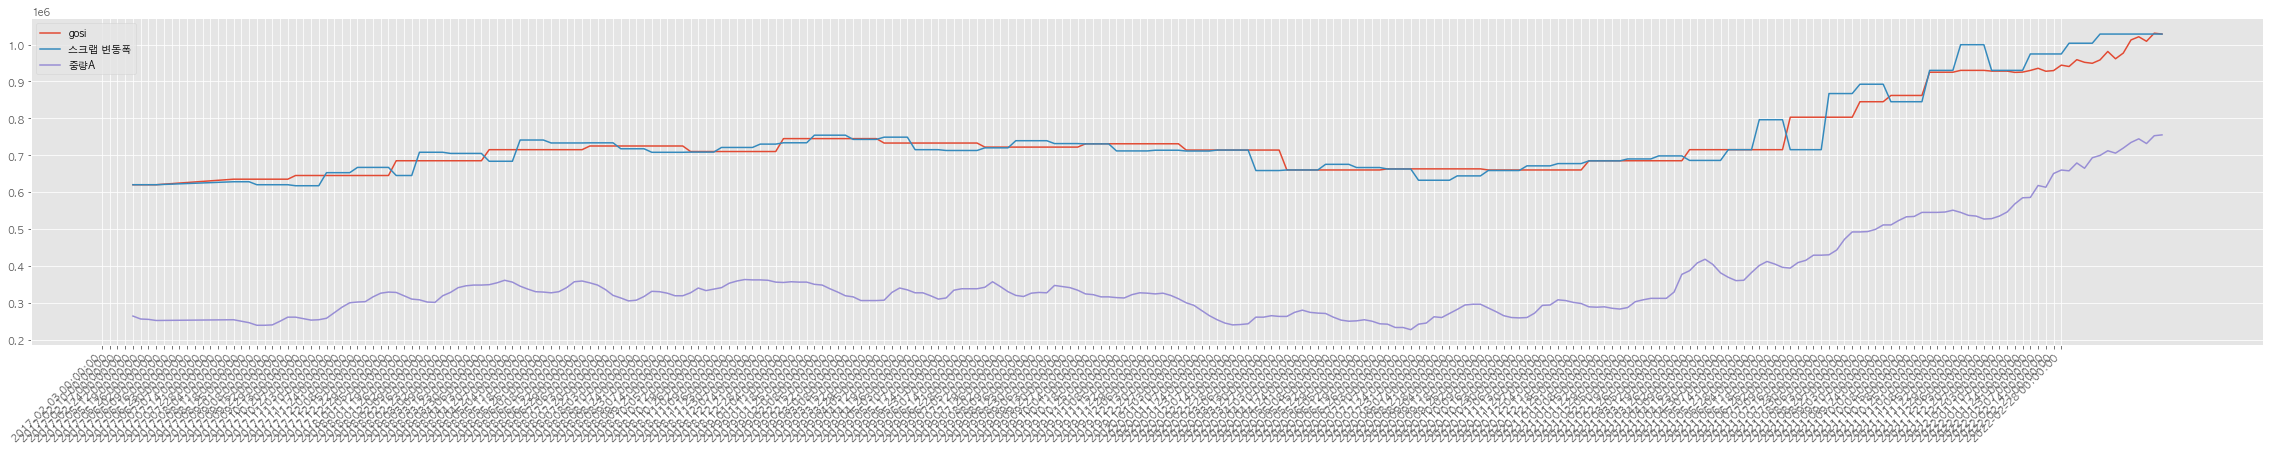

In [94]:
df = df[df['scrap_gap']>0]
import matplotlib.pyplot as plt
plt.rc('font', family='AppleGothic')
plt.style.use('ggplot')
plt.rcParams["figure.figsize"] = (40,6)
xi = list(range(len(df)))
fig = plt.figure()
ay= fig.add_subplot(111)
ay.plot(df.index, df['gosi'], label = 'gosi')
ay.plot(df.index, df['scrap_gap'] , label = '스크랩 변동폭')
ay.plot(df.index, df['weightA'], label='중량A')
#ay.plot(df.index, df['importPriceJP'], label='일본 H2')
#ay.plot(df.index, df['importPriceUSA'], label = "미국(대형-벌크)")

plt.xticks(xi, df['date'])
plt.legend()


ay.set_xticklabels(df['date'], rotation = 45, ha="right")

plt.show()

fig.savefig('./result_img01/fig2.png', dpi = 100)

In [96]:
df.tail(100)

,date,date.1,weightA,gosi,priceUSA_TAIWAN,priceJP,priceCN,importPriceUSA,importPriceJP,stock,USD_KR,JPY_KR,scrap,stock_trend,quarter,scrap_gap
167,2020-04-10,2020-04-10,233000.0000,663000.0,239976.0,202390.60,444804.0,316332.00,224220.0,1034.00,1212.00,1118.18,239577.20000,909.791596,2020.2,6.626270e+05
168,2020-04-17,2020-04-17,233000.0000,663000.0,259221.0,204347.20,446639.0,317637.00,225145.0,976.00,1217.00,1128.99,239892.70000,908.716283,2020.2,6.626270e+05
169,2020-04-24,2020-04-24,227000.0000,663000.0,274847.5,203710.30,452327.5,321682.50,228012.5,919.00,1232.50,1144.44,236670.75000,907.640971,2020.2,6.626270e+05
170,2020-05-01,2020-05-01,242000.0000,663000.0,276713.0,202565.90,447373.0,318159.00,225515.0,905.00,1219.00,1144.44,246318.90000,906.565659,2020.2,6.321561e+05
171,2020-05-08,2020-05-08,245000.0000,663000.0,267399.0,203242.00,395604.0,318681.00,262515.0,809.00,1221.00,1148.26,255871.10000,905.490346,2020.2,6.321561e+05
172,2020-05-15,2020-05-15,262000.0000,663000.0,281784.5,202248.60,398682.0,313777.50,283015.0,748.00,1230.50,1149.14,271380.75000,904.415034,2020.2,6.321561e+05
173,2020-05-22,2020-05-22,260000.0000,663000.0,285315.0,203019.50,401922.0,316327.50,285315.0,765.00,1240.50,1153.52,270695.75000,903.339721,2020.2,6.321561e+05
174,2020-05-29,2020-05-29,271000.0000,663000.0,284625.0,208845.00,400950.0,315562.50,290812.5,767.00,1237.50,1153.84,279418.75000,902.264409,2020.2,6.321561e+05
175,2020-06-05,2020-06-05,282000.0000,663000.0,286533.0,215804.60,429195.0,308295.00,296205.0,826.00,1209.00,1106.69,287470.50000,901.189096,2020.2,6.439527e+05
176,2020-06-12,2020-06-12,294000.0000,663000.0,294735.0,236575.30,427065.0,306765.00,306765.0,783.00,1203.00,1121.21,297829.50000,900.113784,2020.2,6.439527e+05
